In [24]:
# This notebook performs a statistical analysis of mice doing the cloud of tones task
# stimulating the dopamine release in the tail of the striatum

In [25]:
# run this on Colab
!rm -rf APE_paper/
!git clone https://github.com/HernandoMV/APE_paper.git
%pip install git+file:///content/APE_paper
%cd APE_paper/doc/figures_notebooks

Cloning into 'APE_paper'...
remote: Enumerating objects: 416, done.
remote: Counting objects: 100% (121/121), done.
remote: Compressing objects: 100% (78/78), done.
remote: Total 416 (delta 54), reused 88 (delta 29), pack-reused 295
Receiving objects: 100% (416/416), 26.29 MiB | 19.04 MiB/s, done.
Resolving deltas: 100% (165/165), done.
  Cloning file:///content/APE_paper to /tmp/pip-req-build-c_oxqhyi
  Running command git clone --filter=blob:none --quiet file:///content/APE_paper /tmp/pip-req-build-c_oxqhyi
  fatal: '/content/APE_paper' does not appear to be a git repository
  fatal: Could not read from remote repository.

  Please make sure you have the correct access rights
  and the repository exists.
  error: subprocess-exited-with-error
  
  × git clone --filter=blob:none --quiet file:///content/APE_paper /tmp/pip-req-build-c_oxqhyi did not run successfully.
  │ exit code: 128
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a pro

In [ ]:
%load_ext autoreload
%autoreload 2
import numpy as np
import pandas as pd
from os.path import exists
import urllib.request
import matplotlib.pylab as plt
import warnings
from ast import literal_eval

from APE_paper.utils import custom_functions as cuf
from APE_paper.utils.misc_utils import update_progress
from APE_paper.plot import make_figures
warnings.filterwarnings('ignore')

In [ ]:
# download data from server
dataset_name = 'DA-optostimulation_dataframe.csv'
url = "https://zenodo.org/record/7261639/files/" + dataset_name
dataset_path = '../../data/' + dataset_name
# download if data is not there
if not exists(dataset_path):
    print('Downloading data...')
    urllib.request.urlretrieve(url, dataset_path)
else:
    print('Data already in directory')
# load
dao_df = pd.read_csv(dataset_path, index_col=0)

In [ ]:
# reconvert column to a diccionary
dao_df['FullGUI'] = [literal_eval(x) for x in dao_df.FullGUI]

In [ ]:
# Select how to group trial numbers to compare
ini_trials = 150 # initial trials without stimulation
ao_trials = 225 # trials without stimulation, after some sampling

#### Generate **Figure 6C**

 - Progress: [####################] 100.0%


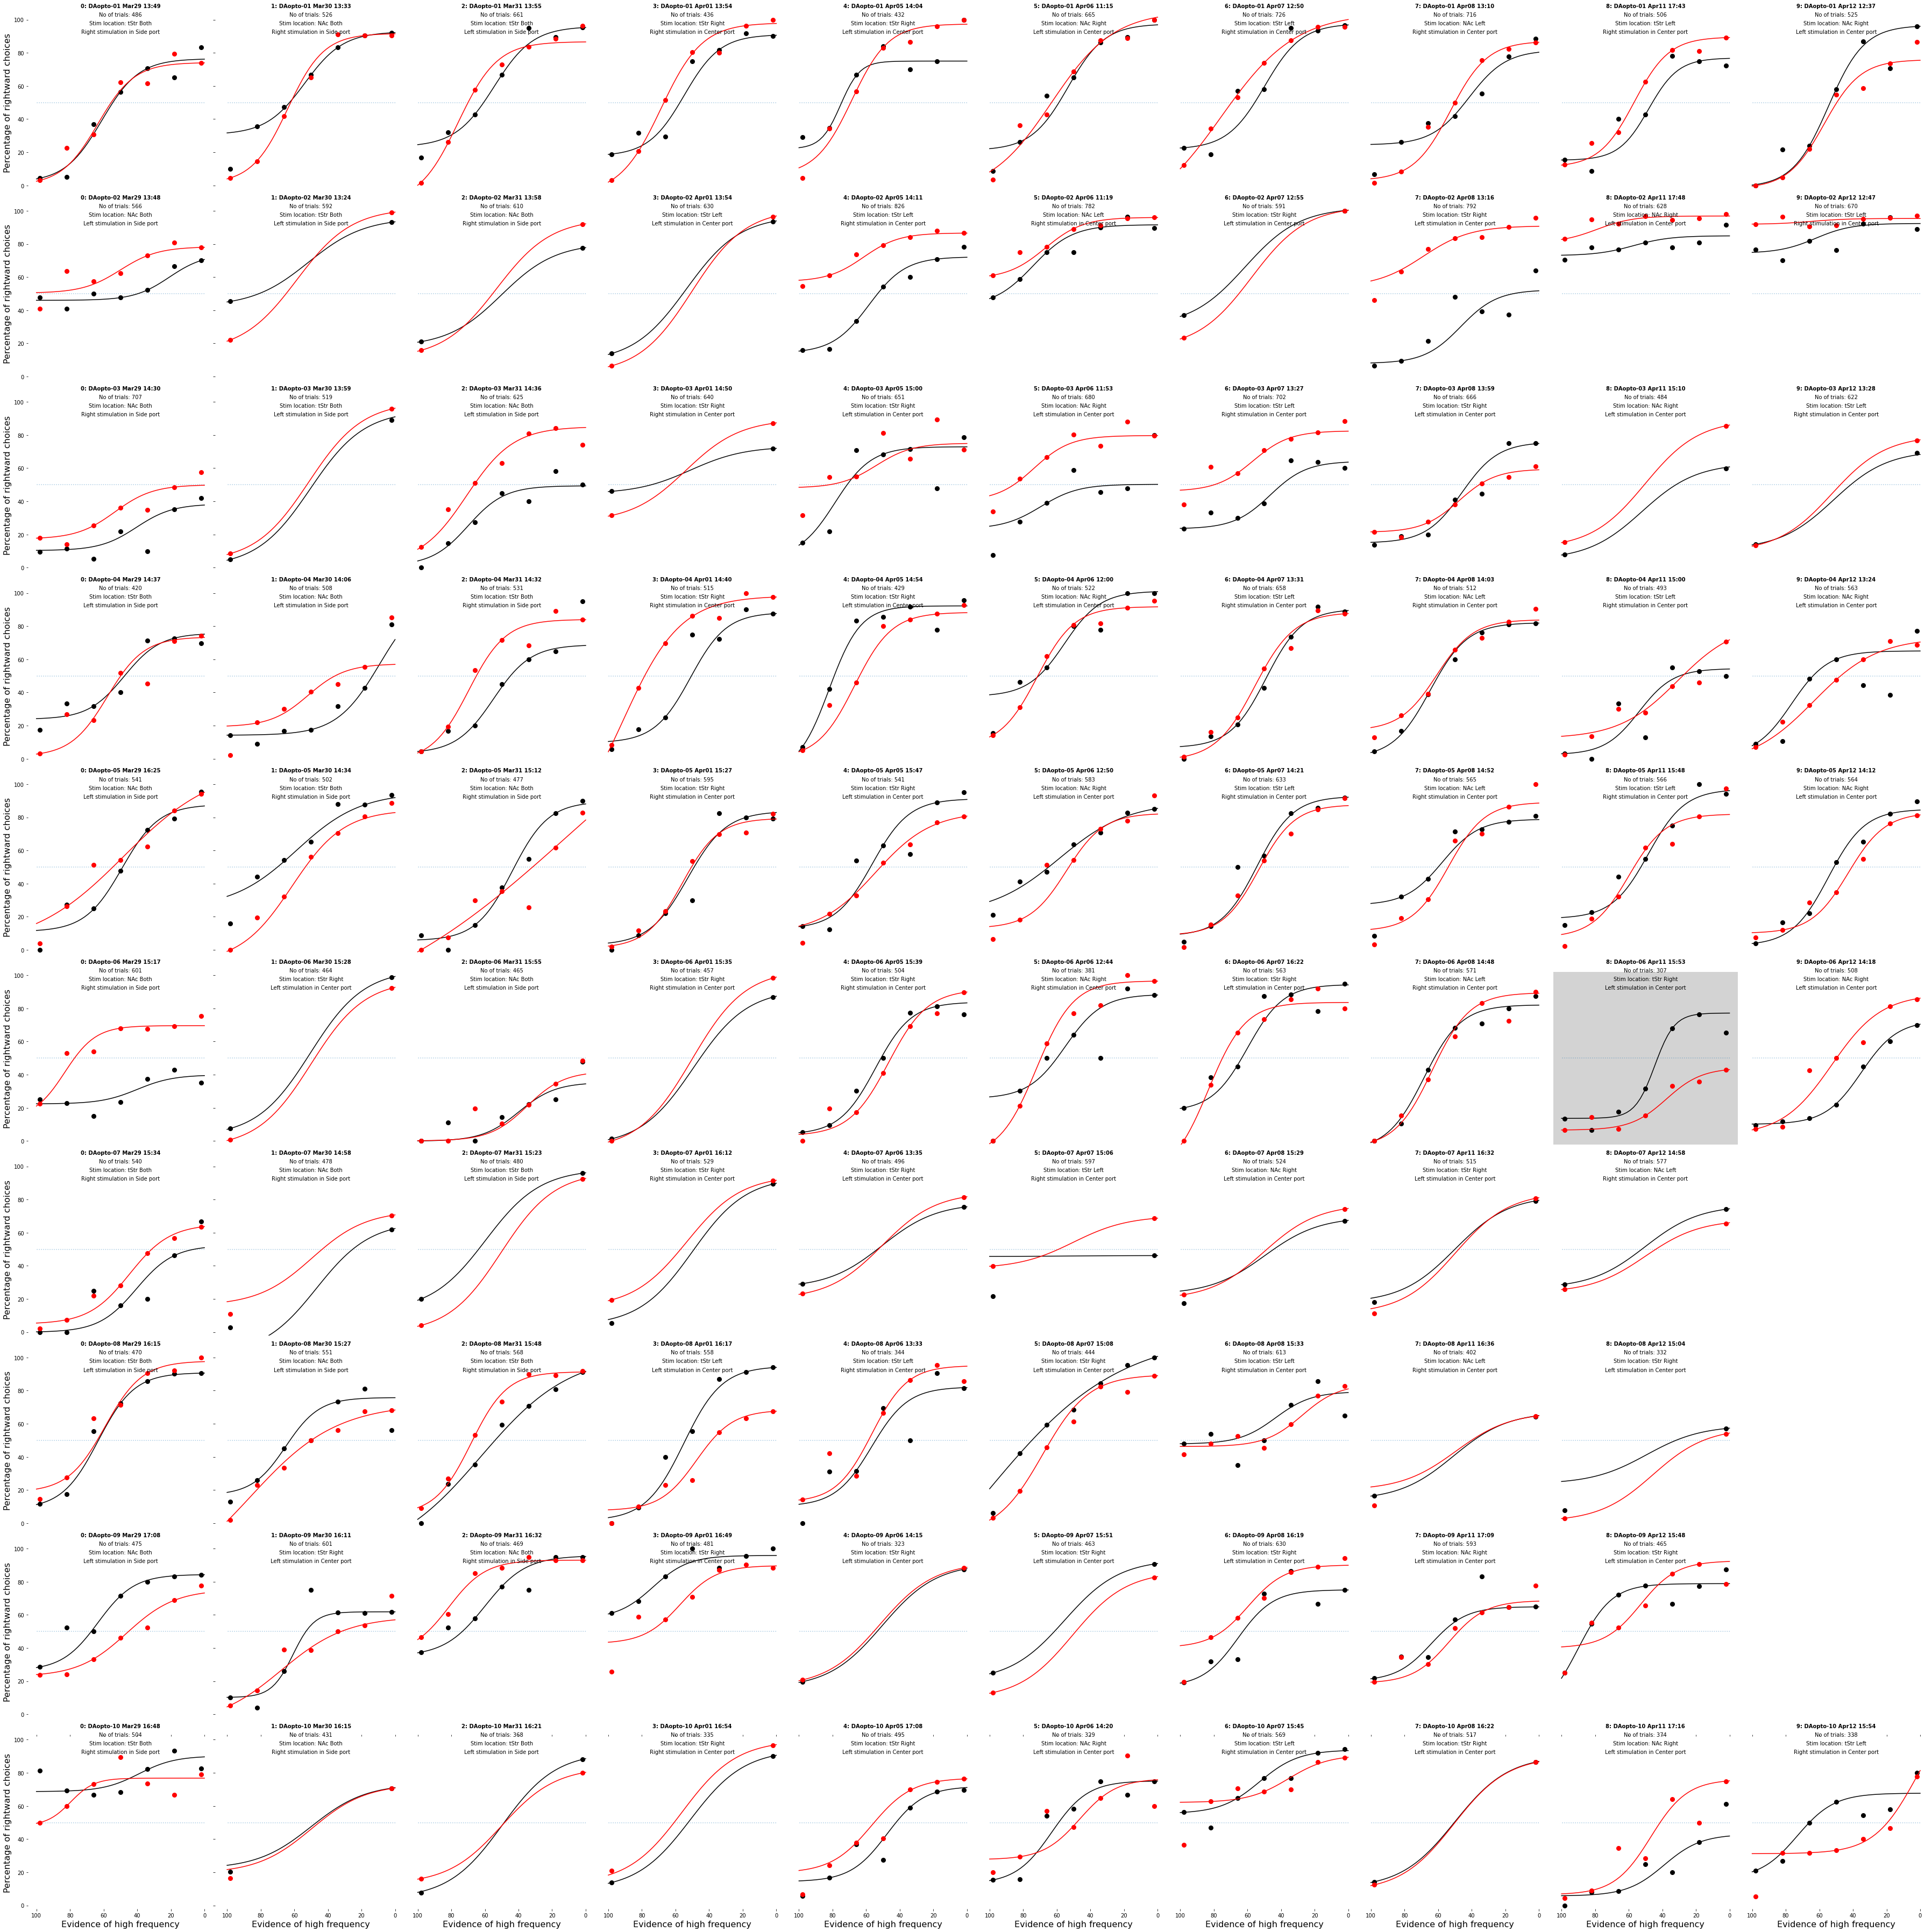

In [ ]:
# see all the sessions done per animal
# highlight the session used as an example in the paper:
example_session = 'DAopto-06 Apr11 15:53'
fig = make_figures.make_figure_opto_da_all_mice(dao_df, ini_trials, ao_trials, example_session)
plt.show(fig)
# uncomment here to save the plot
# data_directory = ''
# plt.savefig(data_directory + 'optoinhibition_through_learning_per-mouse.pdf',
#             transparent=True, bbox_inches='tight')


In [26]:
# Generate another dataset for every session containing information about the difference between
# the optostimulated trials and the normal ones, as well as random differences, calculated
# shuffling the trial indexes
n_times = 1000 # number of shuffles
opto_df = cuf.get_dopamine_optostimulation_differences_dataframe(dao_df, ini_trials,
                                                                 ao_trials, n_times)

 - Progress: [####################] 100.0%


In [27]:
# remove NAc DAopto-03 as the fibers are not correctly placed DV
idx_to_remove = opto_df[np.logical_and(opto_df.AnimalID=='DAopto-03',
                                       opto_df.FiberArea=='NAc')].index

opto_df.drop(idx_to_remove, inplace=True)

In [28]:
# remove tStr DAopto-05 L as the fiber is a bit anterior
idx_to_remove = opto_df[np.logical_and(np.logical_and(opto_df.AnimalID=='DAopto-05',
                                                      opto_df.FiberArea=='tStr'),
                                       opto_df.FiberSide=='Left')].index

opto_df.drop(idx_to_remove, inplace=True)

In [29]:
# Subselect the dataframe based on some conditions
#### conditions 
# remove sessions in which initially the mouse is very bias
extreme_ini_bias = 100/3
conditions = opto_df.Protocol.isin(['Aud_Psycho', 'Auditory'])
conditions = np.logical_and(conditions, extreme_ini_bias < opto_df.InitialBias)
conditions = np.logical_and(conditions, (100 - extreme_ini_bias) > opto_df.InitialBias)
# select those sessions for which the stimulation happens in contralateral trials
# this emulates the physiological conditions
conditions = np.logical_and(conditions, opto_df.Contralateral==True)
# select those sessions in which the stimulation happens when the animal is in the cent port
# this tests for state-action associations
conditions = np.logical_and(conditions, opto_df.StimPort=='Center')

opto_df_sel = opto_df[conditions].copy()

In [30]:
# If several sessions exist for one mouse on the same conditions of hemisphere
# and stimulated side, combine them (average results)

opto_df_sel = cuf.merge_repeated_cases_for_dopamine_optostimulation(opto_df_sel)

#### Generate **Figure 6D**

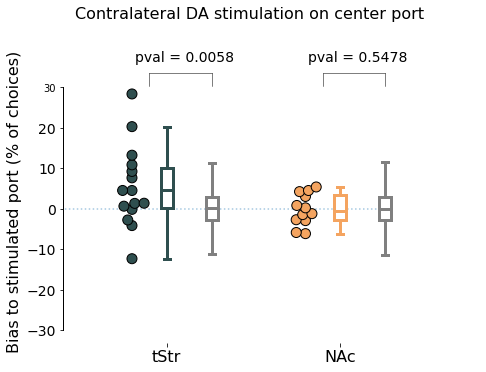

In [36]:
fig = make_figures.make_figure_opto_da_boxplots(opto_df_sel, hor = ['tStr', 'NAc'],
                                                tit='Contralateral DA stimulation on center port')
plt.show(fig)
# uncomment here to save the plot
# data_directory = ''
# plt.savefig(data_directory + 'dopamine_optostimulation_centerport.pdf',
#             transparent=True, bbox_inches='tight')

#### Generate **Figure 6F**

In [32]:
# Subselect the dataframe based on some conditions
#### conditions 
# remove sessions in which initially the mouse is very bias
conditions = opto_df.Protocol.isin(['Aud_Psycho', 'Auditory'])
conditions = np.logical_and(conditions, extreme_ini_bias < opto_df.InitialBias)
conditions = np.logical_and(conditions, (100 - extreme_ini_bias) > opto_df.InitialBias)
# select those sessions for which the stimulation is not labeled as contralateral
# as the stimulation was bilateral
conditions = np.logical_and(conditions, opto_df.Contralateral==False)
# select those sessions in which the stimulation happens when the animal is in the cent port
# this tests for state-action associations
conditions = np.logical_and(conditions, opto_df.StimPort=='Side')
conditions = np.logical_and(conditions, opto_df.FiberArea=='tStr')

opto_df_sideport = opto_df[conditions].copy()

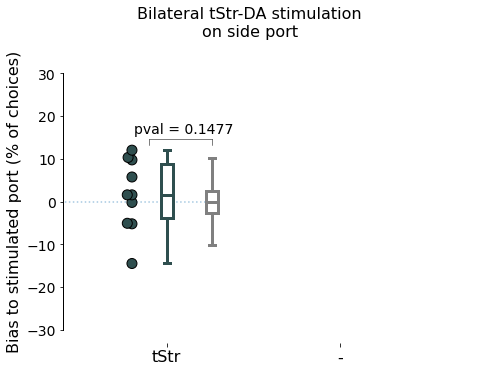

In [40]:
fig = make_figures.make_figure_opto_da_boxplots(opto_df_sideport, hor = ['tStr', '-'],
                                                tit='Bilateral tStr-DA stimulation\non side port')
plt.show(fig)
# uncomment here to save the plot
# data_directory = ''
# plt.savefig(data_directory + 'dopamine_optostimulation_sideport.pdf',
#             transparent=True, bbox_inches='tight')